In [30]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import Image
import imageio.v2
import csv

import tqdm as tqdm
import jax 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from iLQR import iLQR, Path



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

iLQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'n': 20, 'dt': 0.05, 'max_iter': 100, 'tol': 0.001, 'line_search_a': 0.1, 'line_search_b': 5.0, 'line_search_c': 0.5, 'reg_min': 1e-06, 'reg_max': 1000000.0, 'reg_init': 1, 'reg_scale_up': 10.0, 'reg_scale_down': 0.5, 'wheelbase': 0.257, 'radius': 0.13, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'huber', 'path_weight': 4.0, 'path_huber_delta': 1.0, 'dim_vel_ref': 3, 'vel_cost_type': 'huber', 'vel_weight': 1.0, 'vel_huber_delta': 0.5, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 1.0, 'dim_progress': 4, 'progress_weight': 2, 'ctrl_cost_type': 'quadratic', 'ctrl_cost_accel_weight': 0.1, 'ctrl_cost_steer_weight': 0.1, 'ctrl_cost_accel_huber_delta': 1.0, 'ctrl_cost_steer_huber_delta': 1.0, 'dim_obs_x': 5, 'dim_obs_y': 6, 'dim_obs_radius': 7, 'obs_a': 8.0, 'obs

iLQR takes : 0.01 sec']: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]
/tmp/ipykernel_41979/426790303.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


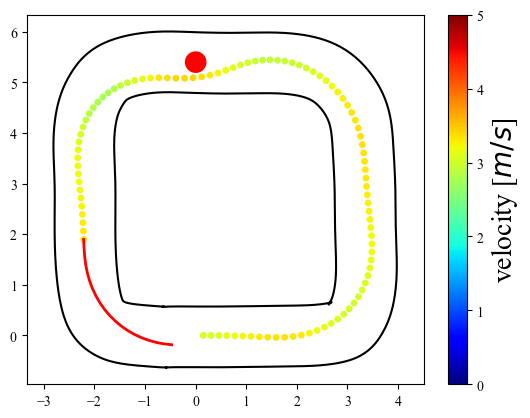

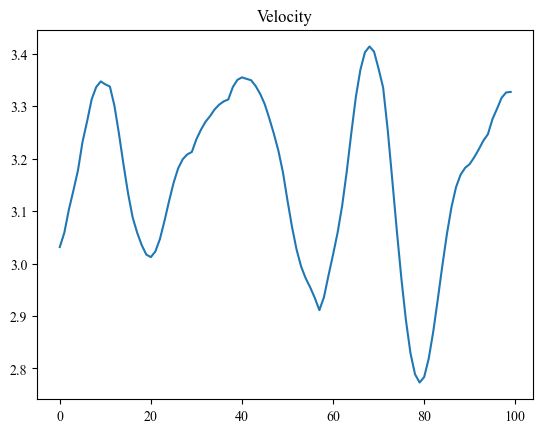

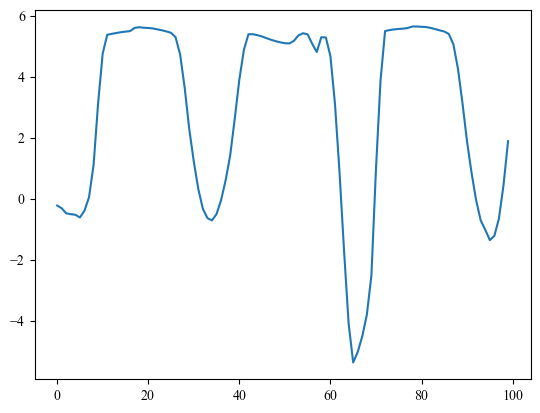

In [213]:
jax.config.update('jax_platform_name', 'cpu')

# Load ILQR
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)

config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR() #(config_file)
solver.update_path(path)

# define some parameters
n = 20
itr_receding = 100
x_cur = np.array([0, 0, 3, 0, 0])  # Initial state.
init_control = np.zeros((2, n))
fig_prog_folder = 'fig/'

state_history = np.zeros((5,itr_receding))
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    
    plan = solver.plan(x_cur, init_control)
    states = plan['states']
    controls = plan['controls']
    x_cur = states[:,1]
    state_history[:,i]  = x_cur
    init_control[:,:-1] = controls[:,1:]
    pbar.set_description(f"iLQR takes : {plan['t_process']:.2f} sec']")
    # plot
    plt.clf()
    path.plot_track()
    sc = plt.scatter(
        state_history[0, :i], state_history[1, :i], s=24,
        c=state_history[2, :i], cmap=cm.jet, vmin=0, vmax=5,
        edgecolor='none', marker='o'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(r"velocity [$m/s$]", size=20)
    
    plt.plot(states[0, :], states[1, :], 'r', linewidth=2)
    circle1 = plt.Circle((0, 5.4), 0.35, color='r')
    plt.gca().add_patch(circle1)
    plt.axis('equal')
    plt.savefig(os.path.join(fig_prog_folder, str(i)+".png"), dpi=200)
plt.close('All')

gif_path = os.path.join(fig_prog_folder, 'rollout.gif')
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(itr_receding):
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)

plt.figure()
plt.plot(state_history[2,:])
plt.title('Velocity')


plt.figure()
a = state_history[2, :]**2 / 0.257 * np.tan(state_history[-1, :])
plt.plot(a)


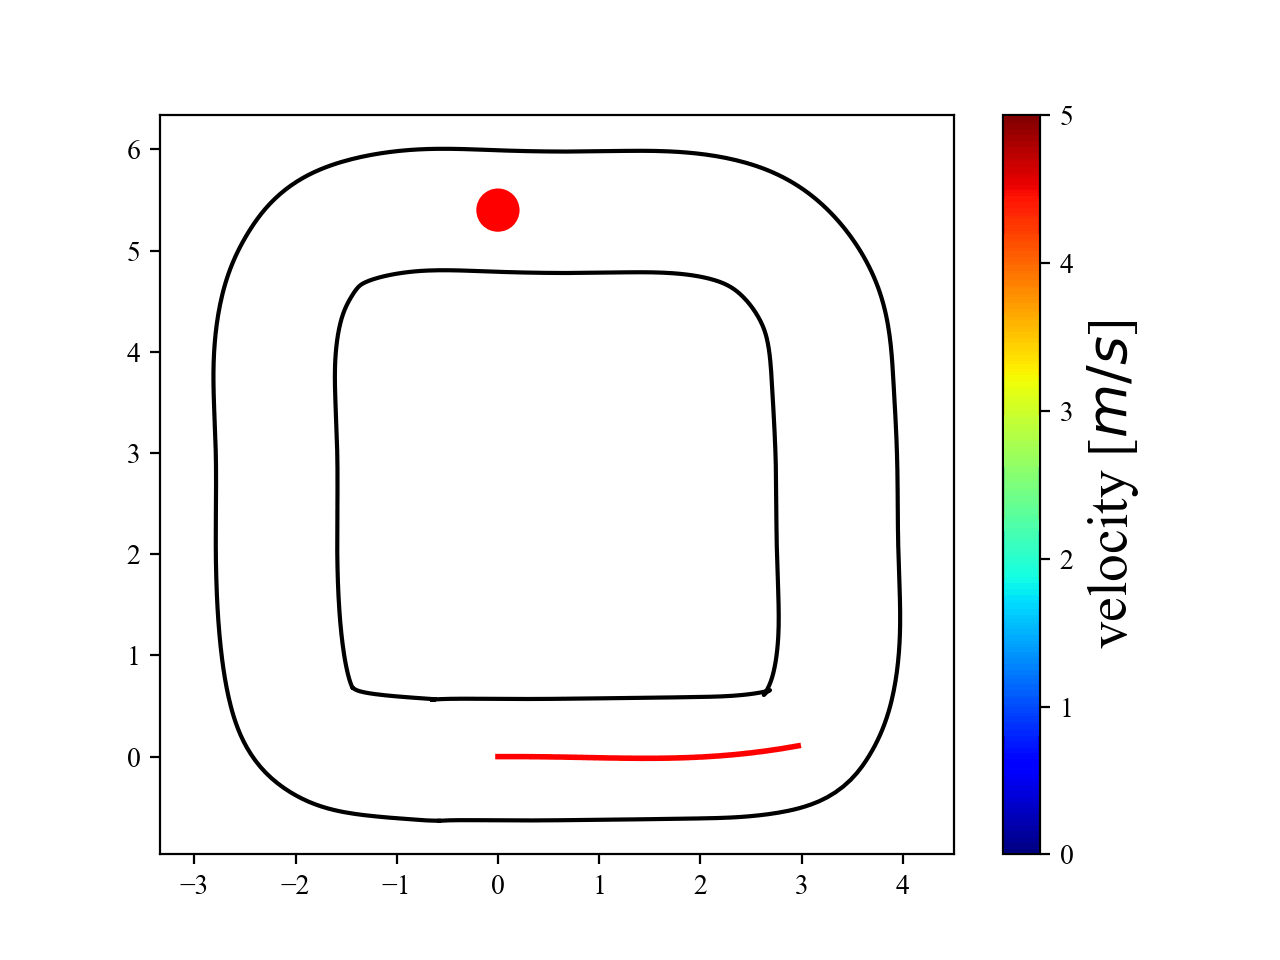

In [209]:
Image(open(gif_path,'rb').read(), width=400)


iLQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'n': 20, 'dt': 0.05, 'max_iter': 100, 'tol': 0.001, 'line_search_a': 0.1, 'line_search_b': 5.0, 'line_search_c': 0.5, 'reg_min': 1e-06, 'reg_max': 1000000.0, 'reg_init': 1, 'reg_scale_up': 10.0, 'reg_scale_down': 0.5, 'wheelbase': 0.257, 'radius': 0.13, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'huber', 'path_weight': 4.0, 'path_huber_delta': 1.0, 'dim_vel_ref': 3, 'vel_cost_type': 'huber', 'vel_weight': 1.0, 'vel_huber_delta': 0.5, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 1.0, 'dim_progress': 4, 'progress_weight': 2, 'ctrl_cost_type': 'quadratic', 'ctrl_cost_accel_weight': 0.1, 'ctrl_cost_steer_weight': 0.1, 'ctrl_cost_accel_huber_delta': 1.0, 'ctrl_cost_steer_huber_delta': 1.0, 'dim_obs_x': 5, 'dim_obs_y': 6, 'dim_obs_radius': 7, 'obs_a': 6.0, 'obs

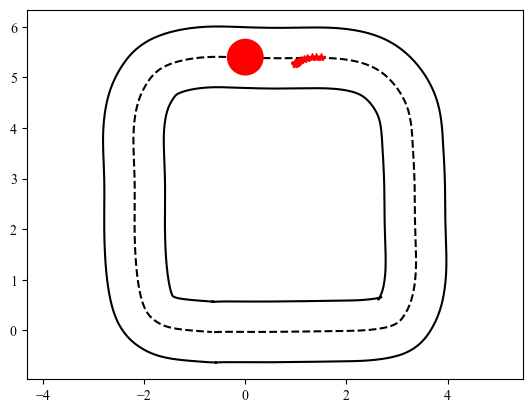

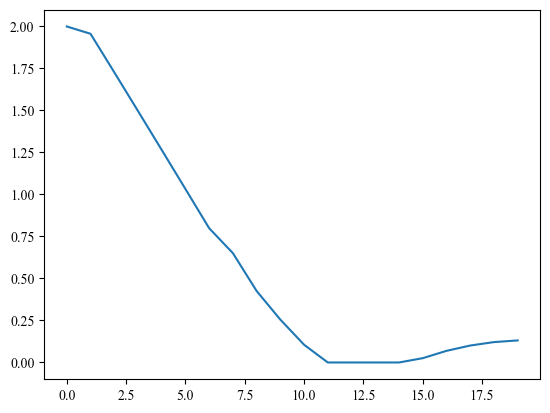

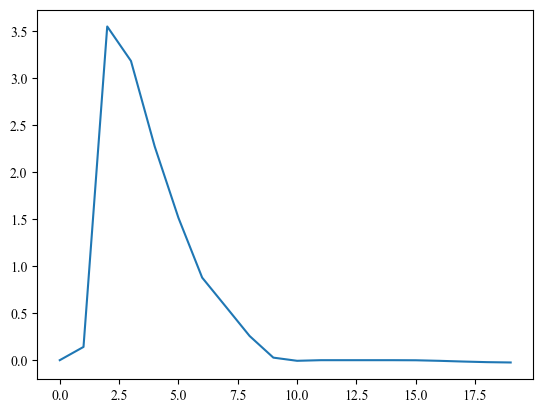

In [220]:
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)
solver = iLQR()
solver.update_path(path)

x_cur = np.array([1.5, 5.4, 1, 3.14, 0])
plan = solver.plan(x_cur)
path.plot_track()
path.plot_track_center()
plt.plot(plan['states'][0, :], plan['states'][1, :], 'r-*', linewidth=2)

circle1 = plt.Circle((0, 5.4), 0.35, color='r')
plt.gca().add_patch(circle1)
plt.axis('equal')

print(plan['status'])

plt.figure()
a = plan['states'][2, :] 
plt.plot(a)

plt.figure()
a = plan['states'][2, :]**2 / 0.257 * np.tan(plan['states'][-1, :])
plt.plot(a)



In [59]:
import jax.numpy as jnp
ego_circles_center = jnp.array([[0,0.257],
                                [0,0]])
state = jnp.array([1,2,3,0,0.2])
psi = 0.5
rot_mat = jnp.array([[jnp.cos(psi), -jnp.sin(psi)],
                    [jnp.sin(psi), jnp.cos(psi)]])

a = jnp.matmul(rot_mat, ego_circles_center)+state[:2].reshape(2,1)
b = a #- jnp.array([[3], [4]])
print(b)
print(jnp.linalg.norm(ego_circles_center, axis=0))

[[1.        1.2255387]
 [2.        2.1232123]]
[0.    0.257]
